# 📊 Загрузка и обогащение данных с Московской биржи техническими индикаторами

## 🔍 Описание индикаторов
При анализе временных рядов в трейдинге и инвестициях используются **технические индикаторы** для выявления трендов, импульса и волатильности рынка. В этом разделе рассматриваются **7 ключевых индикаторов**:

1. **EMA_15, EMA_75 (Экспоненциальные скользящие средние)**  
   - **EMA_15** – короткосрочный тренд (реагирует быстрее).  
   - **EMA_75** – долгосрочный тренд (медленнее меняется).  

2. **ADX (Average Directional Index, индекс тренда)**  
   - Показывает **силу тренда** без учета его направления.  
   - **ADX > 25** – сильный тренд, **ADX < 20** – слабый тренд или флэт.  

3. **DI+ (Positive Directional Indicator) и DI- (Negative Directional Indicator)**  
   - **DI+** измеряет силу восходящего тренда.  
   - **DI-** измеряет силу нисходящего тренда.  
   - Если **DI+ > DI-**, тренд **восходящий**, если **DI- > DI+**, тренд **нисходящий**.  

4. **RSI_14 (Relative Strength Index, индекс относительной силы)**  
   - Оценивает **перекупленность/перепроданность** актива.  
   - **RSI > 70** – перекупленность, возможна коррекция.  
   - **RSI < 30** – перепроданность, возможен отскок вверх.  

5. **ATR_14 (Average True Range, средний истинный диапазон)**  
   - Показывает **волатильность** рынка.  
   - Чем выше ATR, тем сильнее колебания цены.  

In [2]:
import requests
import pandas as pd
import numpy as np
import pandas_ta as ta

from datetime import datetime, timedelta
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

def load_and_prepare_data():
    """
    Загружает данные с MOEX (SBER), рассчитывает технические индикаторы
    и возвращает DataFrame со столбцами:
    [Open, High, Low, Close, Volume, EMA_15, EMA_75, ADX, DI+, DI-, RSI_14, ATR_14]
    и индексом datetime.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3650)  # 10 лет
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    start_index = 0
    batch_size = 500
    all_candles_data = []

    while True:
        url = (
            f'http://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/'
            f'securities/SBER/candles.json?from={start_date_str}&till={end_date_str}'
            f'&interval=60&start={start_index}'
        )
        
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
        }

        response = requests.get(url, headers=headers, timeout=15)
        
        data = response.json()
        candles_data = data['candles']['data']
        if not candles_data:
            break
        all_candles_data.extend(candles_data)
        start_index += batch_size

    df = pd.DataFrame(all_candles_data, columns=data['candles']['columns'])
    df['begin'] = pd.to_datetime(df['begin'])
    df.set_index('begin', inplace=True)
    df.rename(
        columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                 'close': 'Close', 'volume': 'Volume'},
        inplace=True
    )
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # -- Рассчитываем индикаторы --
    df['EMA_15'] = ta.ema(df['Close'], length=15)
    df['EMA_75'] = ta.ema(df['Close'], length=75)

    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['ADX'] = adx['ADX_14']
    df['DI+'] = adx['DMP_14']
    df['DI-'] = adx['DMN_14']
    df['RSI_14'] = ta.rsi(df['Close'], length=14)
    df['ATR_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    df.dropna(inplace=True)
    return df

# ========================
# 1. Загрузка и подготовка
# ========================
df = load_and_prepare_data()

# Сортируем по времени (индексу)
df.sort_index(inplace=True)

# 📊 Разложение временного ряда на тренд, сезонность и шум в рыночных данных

## 🔍 Почему важно разложение временного ряда?
При анализе финансовых рынков мы часто работаем с временными рядами, где цена актива изменяется во времени. Однако это изменение состоит из **трех ключевых компонентов**:

1. **📈 Тренд (Trend)** – долгосрочное направление движения цены.  
2. **🔄 Сезонность (Seasonality)** – повторяющиеся паттерны, связанные с циклами рынка.  
3. **📉 Остаток/шум (Residual)** – случайные колебания, которые не поддаются предсказанию.  

Разделяя эти компоненты, мы можем **лучше понять структуру рынка**, отделяя важные сигналы от шума.

---

## 🚀 **Почему выбираем мультипликативную модель для рыночных данных?**
Разложение временного ряда бывает **аддитивным** и **мультипликативным**:

- **Аддитивная модель (`additive`)** предполагает, что колебания сезонности **имеют постоянную амплитуду** независимо от тренда:
  $$
  Y(t) = Trend(t) + Seasonality(t) + Residual(t)
  $$
  ✅ Подходит для **стабильных данных** (например, температура, средние продажи).

- **Мультипликативная модель (`multiplicative`)** предполагает, что **амплитуда сезонности и шума увеличивается вместе с трендом**:
  $$
  Y(t) = Trend(t) \times Seasonality(t) \times Residual(t)
  $$
  ✅ Лучше всего подходит для **финансовых рынков**, где:
  - Чем выше цена актива, тем **сильнее колебания** (волатильность растет).  
  - Сезонность выражается **в процентных изменениях**, а не в абсолютных значениях.  
  - Фондовые рынки **склонны к экспоненциальному росту**. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

# Предполагаем, что у нас есть датафрейм df и столбец временного ряда
time_series_column = 'Close'  # Укажите название столбца с временным рядом

# Проверяем наличие столбца с датами и устанавливаем его в качестве индекса
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Заполняем пропущенные значения интерполяцией (если необходимо)
df[time_series_column] = df[time_series_column].interpolate()

# Выполняем сезонное разложение
period = 1000  # Подберите нужный период для сезонности
decomposition = seasonal_decompose(df[time_series_column], model='multiplicative', period=period)

# Построение графиков компонентов
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axes[0].plot(df.index, decomposition.observed, label='Observed', color='black')
axes[0].set_title('Original Time Series')
axes[0].legend()

axes[1].plot(df.index, decomposition.trend, label='Trend (Seasonal Decomposition)', color='blue')
axes[1].set_title('Trend (Seasonal Decomposition)')
axes[1].legend()

axes[2].plot(df.index, decomposition.seasonal, label='Seasonality', color='green')
axes[2].set_title('Seasonality')
axes[2].legend()

axes[3].plot(df.index, decomposition.resid, label='Residual (Noise)', color='red')
axes[3].set_title('Residual (Noise)')
axes[3].legend()

plt.tight_layout()
plt.show()


# ACF

Мы выбрали 14 лагов для использования в моделях, поскольку это было максимальное значение, при котором автокорреляционная функция (ACF) демонстрировала значимую зависимость. Анализ ACF позволил определить, что наибольшая статистическая значимость наблюдается именно при этом количестве лагов, что указывает на наличие автокорреляции в пределах данного временного горизонта. Выбор 14 лагов позволяет наиболее полно учесть временную структуру данных и предотвратить потерю информации при расчете доходностей.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Предположим, что df уже содержит данные с 'Close'
df['Returns'] = df['Close'].pct_change().dropna()  # Доходности

# Строим ACF для доходностей
plt.figure(figsize=(10, 5))
plot_acf(df['Returns'].dropna(), lags=30)  # Используем доходности вместо цен
plt.title("Автокорреляционная функция (ACF) доходностей")
plt.show()

# Empirical Mode Decomposition (EMD) — Эмпирическое разложение мод

## 🔍 Что такое EMD?
**Empirical Mode Decomposition (EMD)** — это метод анализа временных рядов, который разлагает сигнал на несколько **Intrinsic Mode Functions (IMF)**. Каждая IMF представляет осциллирующую компоненту сигнала с разными частотами, позволяя выделять скрытые тренды и шумовые компоненты.

Этот метод особенно полезен для **нелинейных и нестационарных временных рядов**, где классические методы (например, Фурье-анализ или Вейвлет-преобразование) могут не давать точных результатов.

---

## 📌 Основные принципы работы EMD
1. **Разделение сигнала на компоненты**
   - Временной ряд раскладывается на несколько **IMF**.
   - IMF представляют собой компоненты сигнала с постепенно убывающей частотой.
   - Последняя IMF обычно соответствует тренду.

2. **Алгоритм разложения (Sifting Process)**
   - Определяются **локальные экстремумы** (максимумы и минимумы).
   - Интерполируются верхняя и нижняя огибающие (например, с помощью сплайнов).
   - Находится разность между исходным сигналом и средней линией огибающих.
   - Этот процесс повторяется, пока разность не станет квазистационарной.
   - Оставшийся остаток считается трендом.

3. **Суммирование IMFs**
   - Можно анализировать каждую IMF отдельно или суммировать их для извлечения низкочастотных трендов.
   
---

## 📊 Применение EMD
🔹 **Финансовый анализ**: Выделение рыночных трендов и фильтрация шума в ценах акций.  
🔹 **Обработка сигналов**: Анализ электрокардиограмм (ЭКГ), аудио-файлов, сейсмических данных.  
🔹 **Климатология и метеорология**: Выявление долгосрочных климатических трендов.  
🔹 **Эконометрические исследования**: Анализ макроэкономических показателей.  


## ✅ Преимущества EMD
✔️ Подходит для **нелинейных и нестационарных** временных рядов.  
✔️ Не требует предположений о структуре данных (в отличие от Фурье-анализа).  
✔️ Выделяет **локальные особенности сигнала** без потерь информации.  

## ❌ Недостатки EMD
⚠️ Может возникать **эффект наложения** (mode mixing), когда разные частоты появляются в одной IMF.  
⚠️ Чувствителен к **выбросам и шуму**.  
⚠️ Вычислительно затратен для больших данных.

---

## 🚀 Улучшенные версии EMD
Чтобы избежать недостатков классического EMD, были разработаны улучшенные методы:

🔹 **Ensemble EMD (EEMD)**: Добавляет случайный белый шум перед разложением, чтобы уменьшить эффект наложения мод.  
🔹 **Complete Ensemble EMD with Adaptive Noise (CEEMDAN)**: Более точный вариант EEMD с адаптивным шумом.  
🔹 **Variational Mode Decomposition (VMD)**: Альтернативный метод, который решает EMD как оптимизационную задачу.

---

## 🎯 Заключение
EMD — это мощный инструмент для анализа временных рядов, особенно когда данные нелинейные и содержат сложные компоненты. Однако, если возникает эффект наложения или данные слишком шумные, стоит рассмотреть улучшенные версии, такие как EEMD или VMD.





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

# Предполагаем, что у нас есть датафрейм df и столбец временного ряда
time_series_column = 'Close'  # Укажите название столбца с временным рядом

# Проверяем наличие столбца с датами и устанавливаем его в качестве индекса
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Заполняем пропущенные значения интерполяцией (если необходимо)
df[time_series_column] = df[time_series_column].interpolate()

# Выполняем EMD разложение
emd = EMD()
imfs = emd(df[time_series_column].values)

# Построение графиков компонентов
fig, axes = plt.subplots(len(imfs) + 1, 1, figsize=(12, 12), sharex=True)

axes[0].plot(df.index, df[time_series_column], label='Original Time Series', color='black')
axes[0].set_title('Original Time Series')
axes[0].legend()

for i, imf in enumerate(imfs):
    axes[i + 1].plot(df.index, imf, label=f'IMF {i+1}', color=np.random.rand(3,))
    axes[i + 1].set_title(f'Intrinsic Mode Function {i+1}')
    axes[i + 1].legend()

plt.tight_layout()
plt.show()

# Complete Ensemble Empirical Mode Decomposition with Adaptive Noise (CEEMDAN)

## 🔍 Что такое CEEMDAN?
**Complete Ensemble Empirical Mode Decomposition with Adaptive Noise (CEEMDAN)** — это усовершенствованная версия **Empirical Mode Decomposition (EMD)** и **Ensemble EMD (EEMD)**, которая устраняет проблему наложения мод (**mode mixing**) за счёт адаптивного добавления шума и улучшенного метода разложения.

### 🔹 Отличие от EMD и EEMD:
- **EMD** разлагает сигнал на осциллирующие компоненты (**Intrinsic Mode Functions, IMF**), но подвержен проблеме наложения мод.
- **EEMD** улучшает EMD, добавляя случайный белый шум перед разложением, но требует усреднения большого количества разложений.
- **CEEMDAN** улучшает EEMD, обеспечивая **адаптивное добавление шума**, что делает процесс более точным и стабильным.

---

## 📌 Основные принципы работы CEEMDAN
1. **Добавление случайного шума** к оригинальному сигналу.
2. **Применение EMD** для извлечения первой IMF.
3. **Адаптивное добавление шума** для последующих IMF (снижает эффект наложения мод).
4. **Повторение процесса** до тех пор, пока не будет получена финальная трендовая компонента.

---

## 📊 Применение CEEMDAN
🔹 **Финансовый анализ**: Удаление шума и анализ скрытых паттернов.  
🔹 **Обработка сигналов**: Фильтрация шумов в медицинских и инженерных данных.  
🔹 **Климатология**: Анализ климатических изменений и тенденций.  
🔹 **Эконометрика**: Выявление бизнес-циклов и экономических трендов.  

## ✅ Преимущества CEEMDAN
✔️ Устраняет проблему **наложения мод** (mode mixing).  
✔️ Обеспечивает **устойчивость к шуму**.  
✔️ Позволяет более точно выделять **тренды** и **циклические компоненты**.  

## ❌ Недостатки CEEMDAN
⚠️ Вычислительно затратен (медленнее, чем EMD и EEMD).  
⚠️ Требует подбора параметров шума.  

---

## 🎯 Заключение
**CEEMDAN** — это одна из самых точных и современных техник разложения временных рядов, позволяющая эффективно фильтровать шум и выделять значимые компоненты. 

Если ваш временной ряд содержит сложные тренды и высокочастотный шум, **CEEMDAN — идеальный выбор!** 🚀



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN

# Предполагаем, что у нас есть датафрейм df и столбец временного ряда
time_series_column = 'Close'  # Укажите название столбца с временным рядом

# Проверяем наличие столбца с датами и устанавливаем его в качестве индекса
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Заполняем пропущенные значения интерполяцией (если необходимо)
df[time_series_column] = df[time_series_column].interpolate()

# Выполняем CEEMDAN разложение
ceemdan = CEEMDAN()
imfs = ceemdan(df[time_series_column].values)

# Построение графиков компонентов
fig, axes = plt.subplots(len(imfs) + 1, 1, figsize=(12, 12), sharex=True)

axes[0].plot(df.index, df[time_series_column], label='Original Time Series', color='black')
axes[0].set_title('Original Time Series')
axes[0].legend()

for i, imf in enumerate(imfs):
    axes[i + 1].plot(df.index, imf, label=f'IMF {i+1}', color=np.random.rand(3,))
    axes[i + 1].set_title(f'Intrinsic Mode Function {i+1}')
    axes[i + 1].legend()

plt.tight_layout()
plt.show()

Обогатим данные IMF-компонентами

In [ ]:
for i in range(imfs.shape[0]):
    df[f'IMF_{i+1}'] = imfs[i]

Выводим гистограмму распределения целей по лонгам и шортам

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Рассчитаем будущие доходности
df['long_future_return'] = df['High'].shift(-14) / df['Close'] - 1
df['short_future_return'] = df['Low'].shift(-14) / df['Close'] - 1

# Определяем границы гистограммы
bins = np.linspace(-0.05, 0.05, 51)  # 50 интервалов в диапазоне [-0.1, 0.1]

# Создаем график
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Гистограмма для long_future_return
axes[0].hist(df['long_future_return'].dropna(), bins=bins, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Long Future Return')
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')

# Гистограмма для short_future_return
axes[1].hist(df['short_future_return'].dropna(), bins=bins, alpha=0.7, color='red', edgecolor='black')
axes[1].set_title('Short Future Return')
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_xlabel('Return')

# Отображаем график
plt.tight_layout()
plt.show()

# 🔹 Краткое описание шагов

1. **Расчет будущей доходности (`future_return`)** - сдвиг цены закрытия на 14 шагов вперед.
2. **Формирование целевой переменной (`target`)** - три класса: рост (1), падение (-1), нейтрально (0).
3. **Преобразование классов для моделей** - (-1, 0, 1) → (0, 1, 2) для XGBoost/CatBoost/LGBM.
4. **Добавление технических индикаторов** - EMA, RSI, ADX, DI+/- и флаги трендов.
5. **Разделение данных** - 70% train, 20% validation, 10% test.
6. **Проверка дисбаланса классов** - расчет частоты и вычисление весов для классов.
7. **Инициализация моделей** - XGBoost и LightGBM с учетом дисбаланса классов.
8. **Обучение моделей** - обучение на train, оценка на validation/test.
9. **Предсказание и оценка качества** - метрики `accuracy_score`, `classification_report`.
10. **Визуализация результатов** - построение confusion matrix для анализа ошибок.

In [4]:
!pip install seaborn

Train class distribution (mapped):
target_mapped
1    0.459030
2    0.290774
0    0.250196
Name: proportion, dtype: float64
Computed class_weights: [3.9968703976435935, 2.178506923540036, 3.43909393315381]
=== XGBoost ===


/home/minakov86/.pyenv/versions/3.10.14/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:57:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "random_seed", "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.5786
Test Accuracy: 0.4674
Classification Report (Test):
              precision    recall  f1-score   support

          -1       0.17      0.08      0.10       758
           0       0.54      0.77      0.63      1622
           1       0.33      0.19      0.24       722

    accuracy                           0.47      3102
   macro avg       0.34      0.35      0.33      3102
weighted avg       0.40      0.47      0.41      3102



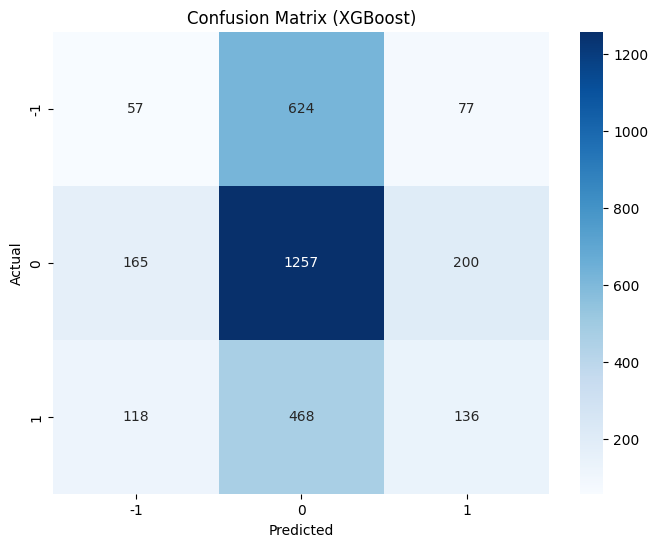


=== LightGBM ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[LightGBM] [Info] Number of data points in the train set: 21711, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Validation Accuracy: 0.5318
Test Accuracy: 0.4549
Classification Report (Test):
              precision    recall  f1-score   support

          -1       0.20      0.15      0.17       758
           0       0.56      0.71      0.62      1622
           1       0.31      0.21      0.25       722

    accuracy                           0.45      3102
   macro avg       0.36      0.36      0.35      3102
weighted avg       0.41      0.45      0.43      3102



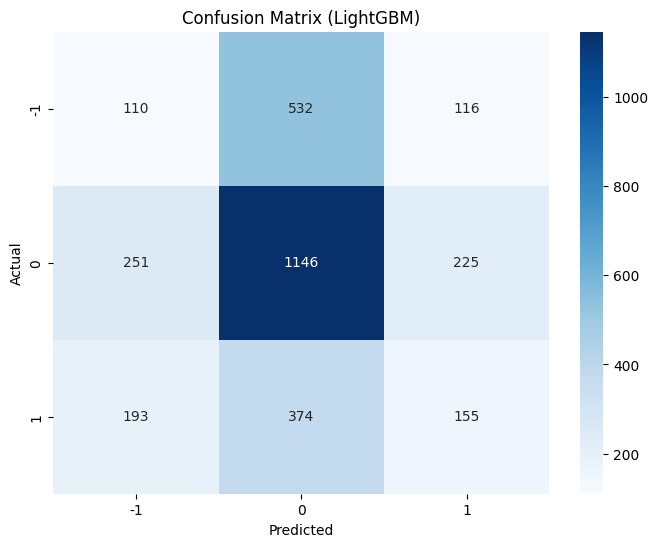

In [5]:
# Рассчитываем future_return на 10 часов вперёд
df['future_return'] = df['Close'].shift(-14) / df['Close'] - 1
df.dropna(subset=['future_return'], inplace=True)

# Формируем таргет (-1, 0, 1)
df['target'] = 0
df.loc[df['future_return'] >  0.01, 'target'] = 1
df.loc[df['future_return'] < -0.01, 'target'] = -1
df['target'] = df['target'].astype(int)

# Т.к. XGBoost/CatBoost/LGB ждут классы 0..2:
# -1 → 0,  0 → 1,  1 → 2
mapping_dict = {-1: 0, 0: 1, 1: 2}
df['target_mapped'] = df['target'].map(mapping_dict)

# 📊 Дополнительные признаки тренда и силы рынка

# 🔹 Разница между краткосрочной и долгосрочной EMA
df['ema_diff'] = df['EMA_15'] - df['EMA_75']  
# ➝ Разница между 15-периодной и 75-периодной экспоненциальной скользящей средней (EMA).
# ➝ Если значение положительное, краткосрочный тренд выше долгосрочного (возможный рост).
# ➝ Если значение отрицательное, краткосрочный тренд ниже долгосрочного (возможное падение).

# 🔹 Флаг: EMA_15 выше EMA_75 (бычий сигнал)
df['ema_15_gt_ema_75'] = (df['EMA_15'] > df['EMA_75']).astype(int)
# ➝ Если EMA_15 выше EMA_75, устанавливаем 1 (сигнал на возможное продолжение роста).
# ➝ Если EMA_15 ниже EMA_75, устанавливаем 0 (возможный нисходящий тренд).

# 🔹 Флаг: RSI пересекает 70 вверх (перекупленность)
df["rsi_above_70"] = (df["RSI_14"] > 70).astype(int)
# ➝ Если RSI выше 70, актив считается перекупленным → возможен откат вниз.
# ➝ Используется как сигнал для фиксации прибыли.

# 🔹 Флаг: RSI пересекает 80 вверх (сильная перекупленность)
df["rsi_above_80"] = (df["RSI_14"] > 80).astype(int)
# ➝ Если RSI выше 80, актив **сильно** перекуплен → высокая вероятность коррекции вниз.
# ➝ Используется как сильный сигнал на фиксацию прибыли.

# 🔹 Флаг: RSI пересекает 20 вниз (перепроданность)
df['rsi_below_20'] = (df['RSI_14'] < 20).astype(int)
# ➝ Если RSI ниже 20, актив **перепродан** → возможен отскок вверх.
# ➝ Используется как сигнал для входа в длинные позиции (покупку).

# 🔹 Флаг: RSI пересекает 30 вниз (слабая перепроданность)
df['rsi_below_30'] = (df['RSI_14'] < 30).astype(int)
# ➝ Если RSI ниже 30, актив **находится в зоне перепроданности**.
# ➝ Возможен разворот вверх, но сигнал слабее, чем при RSI < 20.

# 📊 Определение силы тренда с помощью ADX

# 🔹 Флаг: Сильный тренд (ADX > 25)
df["adx_strong_trend"] = (df["ADX"] > 25).astype(int)
# ➝ Если ADX выше 25, тренд считается сильным.
# ➝ В таком случае DI+ и DI- подскажут направление тренда.

# 🔹 Флаг: Слабый тренд (ADX < 20) или флэт
df["adx_weak_trend"] = (df["ADX"] < 20).astype(int)
# ➝ Если ADX ниже 20, тренд слабый или рынок находится во флэте.
# ➝ В таких условиях индикаторы тренда (DI+ и DI-) менее надежны.

# 📊 Направление тренда на основе DI+ и DI-

# 🔹 Флаг: Восходящий тренд (DI+ > DI-)
df["di_up_trend"] = (df["DI+"] > df["DI-"]).astype(int)
# ➝ Если DI+ выше DI-, актив в восходящем тренде.

# 🔹 Флаг: Нисходящий тренд (DI- > DI+)
df["di_down_trend"] = (df["DI-"] > df["DI+"]).astype(int)
# ➝ Если DI- выше DI+, актив в нисходящем тренде.

# 📊 Комбинированные признаки силы тренда

# 🔹 Флаг: Сильный восходящий тренд (ADX > 25 и DI+ > DI-)
df["strong_up_trend"] = ((df["ADX"] > 25) & (df["DI+"] > df["DI-"])).astype(int)
# ➝ Если ADX выше 25 и DI+ выше DI-, тренд сильный и восходящий.
# ➝ Это **подтвержденный бычий сигнал**.

# 🔹 Флаг: Сильный нисходящий тренд (ADX > 25 и DI- > DI+)
df["strong_down_trend"] = ((df["ADX"] > 25) & (df["DI-"] > df["DI+"])).astype(int)
# ➝ Если ADX выше 25 и DI- выше DI+, тренд сильный и нисходящий.
# ➝ Это **подтвержденный медвежий сигнал**.

ohlcv = ['Open', 'High', 'Low', 'Close', 'Volume']
futr_exog_cols = ['EMA_15', 'EMA_75', 'ADX', 'DI+', 'DI-', 'RSI_14', 'ATR_14']
additional_cols = [
    'ema_diff', 'ema_15_gt_ema_75',  # Разница EMA и флаг пересечения
    'rsi_above_70', 'rsi_above_80',  # RSI выше 70 и 80
    'rsi_below_20', 'rsi_below_30',  # RSI ниже 20 и 30
    'adx_strong_trend', 'adx_weak_trend',  # Сила тренда по ADX
    'di_up_trend', 'di_down_trend',  # Направление тренда по DI+ и DI-
    'strong_up_trend', 'strong_down_trend'  # Комбинированные признаки сильного тренда
]
features = ohlcv + futr_exog_cols + additional_cols

# ====================================
# 2. Деление на Train / Val / Test
# ====================================
n = len(df)
train_end = int(n * 0.7)
val_end   = int(n * 0.9)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

X_train, y_train = train_df[features], train_df['target_mapped']
X_val,   y_val   = val_df[features],   val_df['target_mapped']
X_test,  y_test  = test_df[features],  test_df['target_mapped']

# =============================
# 3. Проверка дисбаланса классов
# =============================
print("Train class distribution (mapped):")
print(y_train.value_counts(normalize=True))

# Автоматически вычислим веса классов как 1 / (доля класса) - упрощенный вариант
# Если класс 0 встречается очень часто, его вес будет меньше, чем у редких классов.
class_counts = y_train.value_counts(normalize=True).sort_index()  # сортировка по индексу (0,1,2)
class_weights = [1.0 / freq for freq in class_counts]
print("Computed class_weights:", class_weights)

# =============================
# 4. Инициализация моделей
# =============================
# -- XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # возвращает метки
    num_class=3,
    eval_metric='mlogloss',
    random_seed = 42,
    scale_pos_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
)
# -- LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_seed = 42,
    class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
)


models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,   
}

# ============================
# 5. Обучение + проверка
# ============================
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# 5. Обучение + проверка
# ============================
for name, model in models.items():
    print(f"=== {name} ===")
    model.fit(X_train, y_train)

    # Предсказываем на валидации
    y_val_pred_mapped = model.predict(X_val)
    # Если вернулись вероятности (2D), берём argmax
    if isinstance(y_val_pred_mapped, np.ndarray) and y_val_pred_mapped.ndim == 2:
        y_val_pred_mapped = np.argmax(y_val_pred_mapped, axis=1)
    val_acc = accuracy_score(y_val, y_val_pred_mapped)

    # Предсказываем на тесте
    y_test_pred_mapped = model.predict(X_test)
    if isinstance(y_test_pred_mapped, np.ndarray) and y_test_pred_mapped.ndim == 2:
        y_test_pred_mapped = np.argmax(y_test_pred_mapped, axis=1)
    test_acc = accuracy_score(y_test, y_test_pred_mapped)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Возвращаем классы из {0,1,2} в {-1,0,1} для отчёта
    inv_map = {0: -1, 1: 0, 2: 1}
    y_test_pred = np.array([inv_map[v] for v in y_test_pred_mapped])
    y_test_orig = np.array([inv_map[v] for v in y_test])

    # Отчёт о классификации на тестовой выборке
    print("Classification Report (Test):")
    print(classification_report(y_test_orig, y_test_pred))

    # Матрица ошибок на тестовой выборке
    cm = confusion_matrix(y_test_orig, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print()


# 🔹 Обучение модели CatBoost и проверка качества

1. **Проверка дисбаланса классов** - вычисляем частоту классов в обучающей выборке.
2. **Расчет `class_weights`** - балансируем классы, чтобы модель лучше обрабатывала редкие события.
3. **Инициализация CatBoostClassifier**:
   - `loss_function='MultiClass'` - многоклассовая классификация.
   - `class_weights` - учитываем дисбаланс классов.
   - `early_stopping_rounds=100` - ранняя остановка при переобучении.
4. **Обучение модели** - тренировочный процесс с валидацией на `X_val, y_val`.
5. **Предсказания на test/val/train** - получаем вероятности классов, затем определяем наиболее вероятный класс (`argmax`).
6. **Обратное преобразование предсказаний** - возвращаем классы в исходный формат (-1, 0, 1).
7. **Вычисление точности (`accuracy_score`)** на обучающем, валидационном и тестовом наборах.
8. **Вывод `classification_report`** - анализ качества классификации.
9. **Матрица ошибок (Confusion Matrix)** - визуализируем предсказания и реальные метки.

In [ ]:
# Проверка дисбаланса классов
print("Distribution of classes in TRAIN (mapped):")
print(y_train.value_counts(normalize=True))

# Вычисление class_weights
class_counts = y_train.value_counts(normalize=True).sort_index()  # индексы классов: 0,1,2
class_weights = [1 / freq for freq in class_counts]
print("Computed class_weights =", class_weights)

# Инициализация CatBoostClassifier
cat_model = CatBoostClassifier(
    loss_function='MultiClass',
    random_seed=42,
    iterations=1000,
    learning_rate=0.05,
    class_weights=class_weights,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=100
)

# Обучение модели
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

# Предсказание на тестовых данных
y_test_pred_proba = cat_model.predict_proba(X_test)  # Вероятности для каждого класса
y_test_pred_mapped = np.argmax(y_test_pred_proba, axis=1)  # Индекс класса с наибольшей вероятностью

# Возвращаем предсказания в формат -1, 0, 1
inv_map = {0: -1, 1: 0, 2: 1}
# Предсказание на обучающей выборке
y_train_pred_proba = cat_model.predict_proba(X_train)
y_train_pred_mapped = np.argmax(y_train_pred_proba, axis=1)
y_train_pred = np.array([inv_map[v] for v in y_train_pred_mapped])
y_train_orig = np.array([inv_map[v] for v in y_train])
train_acc = accuracy_score(y_train_orig, y_train_pred)

# Предсказание на валидационной выборке
y_val_pred_proba = cat_model.predict_proba(X_val)
y_val_pred_mapped = np.argmax(y_val_pred_proba, axis=1)
y_val_pred = np.array([inv_map[v] for v in y_val_pred_mapped])
y_val_orig = np.array([inv_map[v] for v in y_val])
val_acc = accuracy_score(y_val_orig, y_val_pred)

# Предсказание на тестовой выборке
y_test_pred_proba = cat_model.predict_proba(X_test)
y_test_pred_mapped = np.argmax(y_test_pred_proba, axis=1)
y_test_pred = np.array([inv_map[v] for v in y_test_pred_mapped])
y_test_orig = np.array([inv_map[v] for v in y_test])
test_acc = accuracy_score(y_test_orig, y_test_pred)

# Вывод accuracy для train/val/test
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Отчёт о классификации на тестовой выборке
print("\nClassification Report (Test):")
print(classification_report(y_test_orig, y_test_pred))

# Матрица ошибок на тестовой выборке
cm = confusion_matrix(y_test_orig, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CatBoost (Test)')
plt.show()

# 🔹 Ансамблевое голосование моделей

1. **Определение ансамбля моделей** - объединяем XGBoost, LightGBM и CatBoost.
2. **Функция `ensemble_voting`** - собирает предсказания всех моделей и выбирает наиболее частый класс (голосование большинством).
3. **Голосование на валидационной выборке** - получаем предсказания ансамбля и вычисляем `accuracy_score`.
4. **Голосование на тестовой выборке** - аналогично, оцениваем качество на тестовом наборе.
5. **Обратное преобразование предсказаний** - переводим классы обратно в (-1, 0, 1).
6. **Вывод `classification_report`** - анализируем точность ансамбля.
7. **Матрица ошибок (Confusion Matrix)** - визуализируем предсказания ансамбля против реальных значений.
8. **Оценка качества ансамбля** - сравниваем точность ансамбля с отдельными моделями.

In [ ]:
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model
}

# ============================
# 6. Голосование ансамбля
# ============================

# Функция для голосования ансамбля
def ensemble_voting(models, X):
    predictions = []
    for name, model in models.items():
        y_pred_mapped = model.predict(X)
        if isinstance(y_pred_mapped, np.ndarray) and y_pred_mapped.ndim == 2:
            y_pred_mapped = np.argmax(y_pred_mapped, axis=1)
        predictions.append(y_pred_mapped)
    
    # Преобразуем список предсказаний в массив
    predictions = np.array(predictions)
    
    # Голосование большинством
    y_pred_ensemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    return y_pred_ensemble

# Голосование на валидационной выборке
y_val_pred_ensemble = ensemble_voting(models, X_val)
val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)

# Голосование на тестовой выборке
y_test_pred_ensemble = ensemble_voting(models, X_test)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)

# Вывод accuracy для голосования ансамбля
print(f"Ensemble Validation Accuracy: {val_acc_ensemble:.4f}")
print(f"Ensemble Test Accuracy: {test_acc_ensemble:.4f}")

# Возвращаем классы из {0,1,2} в {-1,0,1} для отчёта
inv_map = {0: -1, 1: 0, 2: 1}
y_test_pred_ensemble_orig = np.array([inv_map[v] for v in y_test_pred_ensemble])
y_test_orig = np.array([inv_map[v] for v in y_test])

# Отчёт о классификации на тестовой выборке для ансамбля
print("\nEnsemble Classification Report (Test):")
print(classification_report(y_test_orig, y_test_pred_ensemble_orig))

# Матрица ошибок на тестовой выборке для ансамбля
cm_ensemble = confusion_matrix(y_test_orig, y_test_pred_ensemble_orig)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Confusion Matrix (Test)')
plt.show()

# 🔹 Ансамблевое голосование с кастомной логикой

1. **Функция `ensemble_voting_custom`** - реализует комбинированный подход к предсказаниям.
   - Если **хотя бы одна модель предсказала 2 (рост)** → финальный прогноз = 2.
   - В остальных случаях применяется **голосование большинством**.
2. **Предсказание на валидационной выборке** - получаем ансамблевые прогнозы и вычисляем `accuracy_score`.
3. **Предсказание на тестовой выборке** - аналогично, оцениваем качество на тестовом наборе.
4. **Вывод `classification_report`** - анализируем точность ансамбля.
5. **Матрица ошибок (Confusion Matrix)** - визуализируем расхождения предсказаний ансамбля и реальных значений.
6. **Оценка качества кастомного ансамбля** - проверяем, насколько улучшилась точность по сравнению с обычным голосованием.

In [ ]:
# =============================
# 6. Голосование ансамбля (с кастомной логикой)
# =============================

def ensemble_voting_custom(models, X):
    """
    Ансамблевый метод предсказания:
    - Классы 0 и 1 предсказываются голосованием (большинство).
    - Если 2 модели предсказали 0, а 1 модель предсказала 2 → итоговый прогноз = 1 (ничего не делать).
    - Если хотя бы 1 модель предсказала класс 2 (рост), то финальный прогноз = 2.
    """
    predictions = []

    # Получаем предсказания всех моделей
    for name, model in models.items():
        y_pred_mapped = model.predict(X)
        if isinstance(y_pred_mapped, np.ndarray) and y_pred_mapped.ndim == 2:
            y_pred_mapped = np.argmax(y_pred_mapped, axis=1)
        predictions.append(y_pred_mapped)

    # Преобразуем список предсказаний в массив
    predictions = np.array(predictions)

    # Финальное предсказание
    y_pred_ensemble = []

    # Обрабатываем каждую точку данных
    for i in range(predictions.shape[1]):  # Идем по каждому объекту
        preds = predictions[:, i]  # Берем предсказания всех моделей для одной точки

        if 2 in preds:
            # Если хотя бы одна модель предсказала 2 (рост) → выбираем 2
            y_pred_ensemble.append(2)
        else:
            # В остальных случаях используем голосование большинством
            y_pred_ensemble.append(np.bincount(preds).argmax())

    return np.array(y_pred_ensemble)

# =============================
# 7. Предсказания ансамбля
# =============================

# Голосование на валидационной выборке
y_val_pred_ensemble = ensemble_voting_custom(models, X_val)
val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)

# Голосование на тестовой выборке
y_test_pred_ensemble = ensemble_voting_custom(models, X_test)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)

# Вывод accuracy для кастомного голосования
print(f"Ensemble Validation Accuracy: {val_acc_ensemble:.4f}")
print(f"Ensemble Test Accuracy: {test_acc_ensemble:.4f}")

# Отчёт о классификации
print("\nEnsemble Classification Report (Test):")
print(classification_report(y_test, y_test_pred_ensemble))

# =============================
# 8. Матрица ошибок ансамбля
# =============================

cm_ensemble = confusion_matrix(y_test, y_test_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom Ensemble Confusion Matrix (Test)')
plt.show()

# 🔹 Гиперпараметрическая оптимизация XGBoost с Optuna

1. **Определение `objective_xgb`** - функция для оптимизации гиперпараметров.
   - Подбираются `max_depth`, `n_estimators`, `subsample`, `colsample_bytree`.
   - Используется `multi:softmax` для многоклассовой классификации.
2. **Создание весов классов (`sample_weight`)** - балансировка дисбаланса данных.
3. **Обучение модели** - XGBoost обучается на `X_train` с учетом весов классов.
4. **Предсказания на валидационной выборке** - оценивается качество модели.
5. **Кастомная метрика** - учитываем только точность для классов 0 (падение) и 2 (рост).
6. **Оптимизация с Optuna** - проводится 50 проб (`n_trials=50`), находит наилучшие гиперпараметры.
7. **Вывод лучших параметров** - показываем оптимальные настройки модели.
8. **Вывод наилучшего результата** - доля правильно предсказанных значимых классов (0 и 2).

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np


def objective_xgb(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 4),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # Обновленный метод
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Обновленный метод
        "random_state": 42,
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
    }
    
    model = xgb.XGBClassifier(**params)

    # Создаем sample_weight на основе весов классов
    sample_weight = y_train.map({0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})

    # Обучаем XGBoost с весами
    model.fit(X_train, y_train, sample_weight=sample_weight)

    # Делаем предсказания
    y_pred = model.predict(X_val)

    # === Кастомная метрика (учет классов 0 и 2) ===
    correct_0 = np.sum((y_pred == 0) & (y_val == 0))  # Верные предсказания падения
    correct_2 = np.sum((y_pred == 2) & (y_val == 2))  # Верные предсказания роста

    total_correct = correct_0 + correct_2  # Сумма правильных предсказаний
    
    return total_correct / len(y_pred)  # Доля значимых классов

# Запускаем Optuna
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

# Лучшие параметры
print("\n🔥 Лучшие параметры для XGBoost:")
print(study_xgb.best_params)
print(f"\n🎯 Лучшая доля значимых классов (0 и 2): {study_xgb.best_value:.4f}")


# 🔹 Гиперпараметрическая оптимизация LightGBM с Optuna

1. **Определение `objective_lgb`** - функция для подбора гиперпараметров.
   - Оптимизируем `max_depth`, `n_estimators`, `subsample`, `colsample_bytree`.
   - Используем `multiclass` в качестве `objective`.
2. **Балансировка классов** - добавляем `class_weight` для учета дисбаланса.
3. **Обучение модели** - LightGBM тренируется на `X_train`.
4. **Предсказания на валидационной выборке** - оцениваем качество модели.
5. **Кастомная метрика** - считаем точность только для классов 0 (падение) и 2 (рост).
6. **Оптимизация с Optuna** - проводим 50 проб (`n_trials=50`) для поиска лучших параметров.
7. **Вывод лучших параметров** - показываем оптимальные гиперпараметры LightGBM.
8. **Вывод лучшей метрики** - доля правильно предсказанных классов 0 и 2.

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np


def objective_lgb(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 4),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "objective": "multiclass",
        "num_class": 3,
        "class_weight": {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]},  # Учет дисбаланса
    }
    
    model = lgb.LGBMClassifier(**params)

    # Обучаем LightGBM
    model.fit(X_train, y_train)

    # Делаем предсказания
    y_pred = model.predict(X_val)

    # === Корректные предсказания для классов 0 и 2 ===
    correct_0 = np.sum((y_pred == 0) & (y_val == 0))  # Верные предсказания падения
    correct_2 = np.sum((y_pred == 2) & (y_val == 2))  # Верные предсказания роста

    total_correct = correct_0 + correct_2  # Сумма правильных предсказаний
    
    return total_correct / len(y_pred)  # Доля корректных значимых предсказаний

# Запускаем Optuna
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=50)

# Лучшие параметры
print("\n🔥 Лучшие параметры для LightGBM:")
print(study_lgb.best_params)
print(f"\n🎯 Лучшая доля корректных значимых предсказаний (0 и 2): {study_lgb.best_value:.4f}")


# 🔹 Обучение и проверка XGBoost и LightGBM (с оптимизированными параметрами)

1. **Инициализация моделей**:
   - `XGBoost` с `max_depth=3`, `n_estimators=525`, `subsample=0.67`, `colsample_bytree=0.9`.
   - `LightGBM` с `max_depth=3`, `n_estimators=700`, `subsample=0.64`, `colsample_bytree=0.76`.
   - Используем `scale_pos_weight` / `class_weight` для учета дисбаланса классов.

2. **Обучение моделей** - XGBoost и LightGBM обучаются на `X_train, y_train`.

3. **Предсказания на валидации и тесте** - оцениваем точность `accuracy_score` на `X_val` и `X_test`.

4. **Обратное преобразование классов** - возвращаем предсказания в диапазон (-1, 0, 1).

5. **Подсчет правильных предсказаний** - отдельно анализируем корректные прогнозы для значимых классов:
   - `-1` (падение) и `1` (рост).

6. **Вывод `classification_report`** - анализируем метрики Precision, Recall, F1-score.

7. **Оценка доли правильно предсказанных значимых классов** (0 и 2) - важный кастомный показатель.

8. **Матрица ошибок (Confusion Matrix)** - визуализируем предсказания и реальное распределение классов.

9. **Вывод результатов** - проверяем, как улучшенные гиперпараметры повлияли на качество классификации.


In [ ]:
# =============================
# 4. Инициализация моделей
# =============================
# -- XGBoost
xgb_model_opt = xgb.XGBClassifier(
    objective='multi:softmax',  # возвращает метки
    max_depth=3, 
    n_estimators=525,
    subsample=0.67,
    colsample_bytree=0.9,
    num_class=3,
    eval_metric='mlogloss',
    random_seed = 42,
    scale_pos_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
)
# -- LightGBM
lgb_model_opt = lgb.LGBMClassifier(
    objective='multiclass',
    max_depth=3,
    n_estimators=700,
    subsample=0.64,
    colsample_bytree=0.76,
    num_class=3,
    random_seed = 42,
    class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
)


models = {
    'XGBoost': xgb_model_opt,
    'LightGBM': lgb_model_opt,   
}

# ============================
# 5. Обучение + проверка
# ============================
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# 5. Обучение + проверка
# ============================
for name, model in models.items():
    print(f"=== {name} ===")
    model.fit(X_train, y_train)

    # Предсказываем на валидации
    y_val_pred_mapped = model.predict(X_val)
    # Если вернулись вероятности (2D), берём argmax
    if isinstance(y_val_pred_mapped, np.ndarray) and y_val_pred_mapped.ndim == 2:
        y_val_pred_mapped = np.argmax(y_val_pred_mapped, axis=1)
    val_acc = accuracy_score(y_val, y_val_pred_mapped)

    # Предсказываем на тесте
    y_test_pred_mapped = model.predict(X_test)
    if isinstance(y_test_pred_mapped, np.ndarray) and y_test_pred_mapped.ndim == 2:
        y_test_pred_mapped = np.argmax(y_test_pred_mapped, axis=1)
    test_acc = accuracy_score(y_test, y_test_pred_mapped)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Возвращаем классы из {0,1,2} в {-1,0,1} для отчёта
    inv_map = {0: -1, 1: 0, 2: 1}
    y_test_pred = np.array([inv_map[v] for v in y_test_pred_mapped])
    y_test_orig = np.array([inv_map[v] for v in y_test])
    
        # Делаем предсказания
    

    # === Корректные предсказания для классов 0 и 2 ===
    correct_0 = np.sum((y_test_pred == -1) & (y_test_orig == -1))  # Верные предсказания падения
    correct_2 = np.sum((y_test_pred == 1) & (y_test_orig == 1))  # Верные предсказания роста

    total_correct = correct_0 + correct_2  # Сумма правильных предсказаний
    
    # Отчёт о классификации на тестовой выборке
    print("Classification Report (Test):")
    print(classification_report(y_test_orig, y_test_pred))
    print(f'Доля правельно предсказанных значимых классов: {total_correct / len(y_test_pred)}')
    # Матрица ошибок на тестовой выборке
    cm = confusion_matrix(y_test_orig, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print()

# 🔹 Ансамблевое голосование моделей (XGBoost, LightGBM, CatBoost)

1. **Определение ансамбля** - объединяем три модели: `XGBoost`, `LightGBM` и `CatBoost`.

2. **Функция `ensemble_voting`** - реализует голосование большинством:
   - Собирает предсказания всех моделей.
   - Применяет `argmax` для выбора наиболее частого класса.

3. **Голосование на валидационной и тестовой выборке** - получаем предсказания ансамбля и оцениваем `accuracy_score`.

4. **Обратное преобразование классов** - переводим предсказания из `{0,1,2}` в `{-1,0,1}`.

5. **Подсчет правильных предсказаний** - анализируем корректные прогнозы для классов:
   - `-1` (падение).
   - `1` (рост).

6. **Вывод `classification_report`** - анализируем метрики Precision, Recall, F1-score.

7. **Оценка доли правильно предсказанных значимых классов** (0 и 2) - кастомная метрика.

8. **Матрица ошибок (Confusion Matrix)** - визуализируем расхождения предсказаний ансамбля с реальными значениями.

9. **Вывод результатов** - проверяем, насколько ансамбль улучшает предсказания по сравнению с отдельными моделями.

In [ ]:
models = {
    'XGBoost': xgb_model_opt,
    'LightGBM': lgb_model_opt,
    'CatBoost': cat_model
}

# ============================
# 6. Голосование ансамбля
# ============================

# Функция для голосования ансамбля
def ensemble_voting(models, X):
    predictions = []
    for name, model in models.items():
        y_pred_mapped = model.predict(X)
        if isinstance(y_pred_mapped, np.ndarray) and y_pred_mapped.ndim == 2:
            y_pred_mapped = np.argmax(y_pred_mapped, axis=1)
        predictions.append(y_pred_mapped)
    
    # Преобразуем список предсказаний в массив
    predictions = np.array(predictions)
    
    # Голосование большинством
    y_pred_ensemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    return y_pred_ensemble

# Голосование на валидационной выборке
y_val_pred_ensemble = ensemble_voting(models, X_val)
val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)

# Голосование на тестовой выборке
y_test_pred_ensemble = ensemble_voting(models, X_test)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)

# Вывод accuracy для голосования ансамбля
print(f"Ensemble Validation Accuracy: {val_acc_ensemble:.4f}")
print(f"Ensemble Test Accuracy: {test_acc_ensemble:.4f}")

# Возвращаем классы из {0,1,2} в {-1,0,1} для отчёта
inv_map = {0: -1, 1: 0, 2: 1}
y_test_pred_ensemble_orig = np.array([inv_map[v] for v in y_test_pred_ensemble])
y_test_orig = np.array([inv_map[v] for v in y_test])    # === Корректные предсказания для классов 0 и 2 ===

correct_0 = np.sum((y_test_pred_ensemble_orig == -1) & (y_test_orig == -1))  # Верные предсказания падения
correct_2 = np.sum((y_test_pred_ensemble_orig == 1) & (y_test_orig == 1))  # Верные предсказания роста

total_correct = correct_0 + correct_2  # Сумма правильных предсказаний

# Отчёт о классификации на тестовой выборке для ансамбля
print("\nEnsemble Classification Report (Test):")
print(classification_report(y_test_orig, y_test_pred_ensemble_orig))
print(f'Доля правельно предсказанных значимых классов: {total_correct / len(y_test_pred)}')
# Матрица ошибок на тестовой выборке для ансамбля
cm_ensemble = confusion_matrix(y_test_orig, y_test_pred_ensemble_orig)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Confusion Matrix (Test)')
plt.show()

# 🔹 Ансамблевое голосование с кастомной логикой

1. **Функция `ensemble_voting_custom`** - реализует специальную логику предсказаний:
   - Если **хотя бы одна модель предсказала 2 (рост)** → финальный прогноз = 2.
   - Если две модели предсказали 0, а одна 2 → финальный прогноз = 1 (остаемся в позиции).
   - В остальных случаях используется **голосование большинством**.

2. **Голосование на валидационной и тестовой выборке** - получаем ансамблевые прогнозы и вычисляем `accuracy_score`.

3. **Подсчет правильных предсказаний** - анализируем корректные прогнозы для классов:
   - `0` (падение).
   - `2` (рост).

4. **Вывод `classification_report`** - анализируем Precision, Recall, F1-score ансамбля.

5. **Оценка доли правильно предсказанных значимых классов** - кастомная метрика.

6. **Матрица ошибок (Confusion Matrix)** - визуализируем расхождения предсказаний ансамбля с реальными значениями.

7. **Вывод результатов** - проверяем, насколько кастомная логика голосования улучшает точность модели.

In [ ]:
# =============================
# 6. Голосование ансамбля (с кастомной логикой)
# =============================

def ensemble_voting_custom(models, X):
    """
    Ансамблевый метод предсказания:
    - Классы 0 и 1 предсказываются голосованием (большинство).
    - Если 2 модели предсказали 0, а 1 модель предсказала 2 → итоговый прогноз = 1 (ничего не делать).
    - Если хотя бы 1 модель предсказала класс 2 (рост), то финальный прогноз = 2.
    """
    predictions = []

    # Получаем предсказания всех моделей
    for name, model in models.items():
        y_pred_mapped = model.predict(X)
        if isinstance(y_pred_mapped, np.ndarray) and y_pred_mapped.ndim == 2:
            y_pred_mapped = np.argmax(y_pred_mapped, axis=1)
        predictions.append(y_pred_mapped)

    # Преобразуем список предсказаний в массив
    predictions = np.array(predictions)

    # Финальное предсказание
    y_pred_ensemble = []

    # Обрабатываем каждую точку данных
    for i in range(predictions.shape[1]):  # Идем по каждому объекту
        preds = predictions[:, i]  # Берем предсказания всех моделей для одной точки

        if 2 in preds:
            # Если хотя бы одна модель предсказала 2 (рост) → выбираем 2
            y_pred_ensemble.append(2)
        else:
            # В остальных случаях используем голосование большинством
            y_pred_ensemble.append(np.bincount(preds).argmax())

    return np.array(y_pred_ensemble)

# =============================
# 7. Предсказания ансамбля
# =============================

# Голосование на валидационной выборке
y_val_pred_ensemble = ensemble_voting_custom(models, X_val)
val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)

# Голосование на тестовой выборке
y_test_pred_ensemble = ensemble_voting_custom(models, X_test)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)

# Вывод accuracy для кастомного голосования
print(f"Ensemble Validation Accuracy: {val_acc_ensemble:.4f}")
print(f"Ensemble Test Accuracy: {test_acc_ensemble:.4f}")
correct_0 = np.sum((y_test_pred_ensemble == 0) & (y_test == 0))  # Верные предсказания падения
correct_2 = np.sum((y_test_pred_ensemble == 2) & (y_test == 2))  # Верные предсказания роста

total_correct = correct_0 + correct_2  # Сумма правильных предсказаний

# Отчёт о классификации
print("\nEnsemble Classification Report (Test):")
print(classification_report(y_test, y_test_pred_ensemble))
print(f'Доля правельно предсказанных значимых классов: {total_correct / len(y_test_pred)}')
# =============================
# 8. Матрица ошибок ансамбля
# =============================

cm_ensemble = confusion_matrix(y_test, y_test_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom Ensemble Confusion Matrix (Test)')
plt.show()

# 🔹 Вспомогательные методы для тестирования на истории

### 📌 `ensemble_predict_single(models, X_single)`
1. Предсказывает класс (-1, 0, 1) для одной строки данных.
2. Собирает предсказания всех моделей из ансамбля.
3. **Логика предсказания**:
   - Если **хотя бы одна модель предсказала 2 (рост)** → итоговое предсказание = **1**.
   - Если **есть смешанные предсказания (0 и 1)** → итоговое предсказание = **0**.
   - В остальных случаях используется **мажоритарное голосование**.

### 📌 `ensemble_predict(models, df)`
1. Делает предсказания для всего DataFrame.
2. Получает предсказания всех моделей одновременно.
3. Применяет **кастомную логику ансамблевого предсказания**:
   - Если **хотя бы одна модель предсказала 2 (рост)** → итоговое предсказание = **1**.
   - Если **есть смешанные предсказания (0 и 1)** → итоговое предсказание = **0**.
   - В остальных случаях используется **голосование большинством**.

### 📌 `ensemble_majority_vote(models, df)`
1. Выполняет **обычное мажоритарное голосование** по предсказаниям всех моделей.
2. Выбирает наиболее частый класс (`argmax` по `bincount`).
3. Работает **без кастомной логики**, просто усредняя предсказания моделей.

### 🛠 **Применение**
Эти методы позволяют **тестировать модели на исторических данных**, выбирая либо кастомную логику (в `ensemble_predict`), либо обычное голосование (`ensemble_majority_vote`).


In [ ]:
import numpy as np

def ensemble_predict_single(models, X_single):
    """
    Ансамблевое предсказание для одной точки данных.
    Возвращает класс -1, 0 или 1 на основе кастомной логики.
    """
    predictions = []
    
    # Получаем предсказания всех моделей
    for name, model in models.items():
        y_pred_mapped = model.predict(X_single.values.reshape(1, -1))  # Преобразуем в нужную форму
        if isinstance(y_pred_mapped, np.ndarray) and y_pred_mapped.ndim == 2:
            y_pred_mapped = np.argmax(y_pred_mapped, axis=1)
        predictions.append(y_pred_mapped[0])  # Берем скалярное значение предсказания
    
    # Преобразуем в массив
    predictions = np.array(predictions)
    
    # Логика предсказания
    if 2 in predictions:
        return 1  # Если хотя бы одна модель предсказала рост (2), то финальный прогноз 1
    elif 0 in predictions and 1 in predictions:
        return 0  # Если есть смешанные предсказания (0 и 1), выбираем 0
    else:
        majority_vote = np.bincount(predictions).argmax()
        return -1 if majority_vote == 0 else 0 if majority_vote == 1 else 1  # Преобразуем 0 в -1
    

def ensemble_predict(models, df):
    """
    Ансамблевое предсказание для всего DataFrame.
    Возвращает массив предсказаний для всех строк df.
    """
    # Получаем предсказания всех моделей сразу для всего DataFrame
    model_preds = []

    for name, model in models.items():
        y_pred = model.predict(df.values)  # Предсказания для всего df сразу
        
        # Если модель возвращает вероятности (например, softmax), преобразуем в классы
        if isinstance(y_pred, np.ndarray) and y_pred.ndim == 2:
            y_pred = np.argmax(y_pred, axis=1)  # Берем наиболее вероятный класс
            
        model_preds.append(y_pred)  # Добавляем предсказания модели

    # Преобразуем в numpy-массив (кол-во моделей x кол-во строк в df)
    model_preds = np.array(model_preds)  

    # Ансамблевое решение: применяем кастомную логику по всем строкам
    final_predictions = []
    for i in range(model_preds.shape[1]):  # Проходим по всем строкам
        predictions = model_preds[:, i]  # Берем предсказания для i-й строки
        
        # Логика ансамбля:
        if 2 in predictions:
            final_predictions.append(1)  # Если хоть одна модель предсказала 2 → предсказание 1
        elif 0 in predictions and 1 in predictions:
            final_predictions.append(0)  # Если есть 0 и 1 → выбираем 0
        else:
            majority_vote = np.bincount(predictions).argmax()  # Мажоритарное голосование
            final_predictions.append(-1 if majority_vote == 0 else 0 if majority_vote == 1 else 1)

    return np.array(final_predictions)

def ensemble_majority_vote(models, df):
    """
    Ансамблевое голосование на основе большинства предсказаний.
    Возвращает массив предсказаний для всех строк df.
    """
    model_preds = []

    for name, model in models.items():
        y_pred = model.predict(df.values)
        
        # Если модель возвращает вероятности, преобразуем в классы
        if isinstance(y_pred, np.ndarray) and y_pred.ndim == 2:
            y_pred = np.argmax(y_pred, axis=1)
            
        model_preds.append(y_pred)
    
    model_preds = np.array(model_preds)  # Преобразуем в numpy-массив
    
    # Применяем мажоритарное голосование
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=model_preds)
    
    return final_predictions


# 🔹 Бэктестинг стратегии на исторических данных для X_train!

### 📌 `AnsamblePredict(Strategy)`
1. **Определение стратегии**:
   - Использует предсказания ансамбля (`signal`).
   - **Коэффициенты TP/SL**: 
     - `tp_coef = 1.02` (Take Profit +2%).
     - `sl_coef = 0.96` (Stop Loss -4%).

2. **Метод `next()`**:
   - **Вход в позицию**: если `signal == 2` и нет открытых сделок → открываем `buy()`.
   - **Выход из позиции**:
     - **Take Profit**: если `High[-1] > entry_price * tp_coef`, закрываем позицию.
     - **Stop Loss**: если `Low[-1] < entry_price * sl_coef`, закрываем позицию.

---

### 📌 Подготовка данных
1. Создаем `DataFrame` с OHLCV-данными (`Open`, `High`, `Low`, `Close`, `Volume`).
2. **Добавляем предсказания ансамбля** (`ensemble_majority_vote`).

---

### 📌 Оптимизация стратегии с `Backtest`
1. **Запуск бэктеста**:
   - `cash=10000` – стартовый капитал.
   - `commission=0.002` – комиссия 0.2%.

2. **Оптимизация параметров**:
   - Подбираем `tp_coef` от **1.005 до 1.05** (0.5% - 5% Take Profit).
   - Подбираем `sl_coef` от **0.95 до 0.995** (Stop Loss -5% - 0.5%).
   - **Целевая метрика**: `Sortino Ratio` (лучший риск-доходность).

3. **Вывод результатов**:
   - Печатаем `stats` – сводную статистику стратегии.
   - Визуализируем график результатов с `bt.plot(resample=False)`.


# 🔹 Преимущества коэффициента Sortino Ratio

### 📌 Что такое Sortino Ratio?
**Sortino Ratio** – это показатель, оценивающий **доходность стратегии с учетом только негативной (убыточной) волатильности**. Он является улучшенной версией **Sharpe Ratio**, который учитывает всю волатильность (как положительную, так и отрицательную).

### ✅ **Преимущества использования Sortino Ratio**
1. **Игнорирует положительную волатильность** 🚀  
   - В отличие от Sharpe Ratio, не штрафует за высокую доходность.
   - Фокусируется только на **убыточных отклонениях**.

2. **Более точная оценка риска** ⚠️  
   - Рассматривает **реальный риск**, связанный с просадками.
   - Игнорирует **естественные колебания прибыли**, не влияющие на стратегию.

3. **Лучше подходит для трейдинга и инвестиций** 📊  
   - Оптимизирует стратегии с учетом **минимизации потерь**, а не всей волатильности.
   - Полезен для **алготрейдинга, инвестиций и управления капиталом**.

4. **Учитывает индивидуальные предпочтения по риску** 🎯  
   - Позволяет оценивать стратегии **с акцентом на защиту капитала**.
   - Чем выше Sortino Ratio, тем **стратегия эффективнее управляет риском**.

5. **Предпочтителен для стратегий с высоким потенциалом роста** 📈  
   - Особенно полезен для **трендовых и импульсных стратегий**, где возможны резкие взлеты.
   - Позволяет отбирать стратегии, **которые приносят прибыль при ограниченных рисках**.

### 🔥 **Вывод**:
Использование **Sortino Ratio** в оптимизации стратегии позволяет находить **оптимальный баланс между доходностью и управлением рисками**, исключая влияние положительной волатильности.

In [ ]:
from backtesting import Strategy
import pandas_ta as ta
import pandas as pd
from backtesting import Backtest

class AnsamblePredict(Strategy):
    tp_coef = 1.02  # Коэффициент Take Profit (например, 1.01 = +1%)
    sl_coef = 0.96  # Коэффициент Stop Loss (например, 0.99 = -1%)
        
    def init(self):       
        # Создаем копию DataFrame один раз при инициализации
        self.counter = 0
        self.entry_price = 0
        
    def next(self):        
        
        # Торговая логика
        if self.data.signal[-1] == 2 and not self.position:
            self.buy()
            self.entry_price = self.data.Close[-1]
            
        elif self.data.High[-1] > self.entry_price * self.tp_coef:
            self.position.close()
        elif self.data.Low[-1] < self.entry_price * self.sl_coef:
            self.position.close()

# Создаем DataFrame с основными ценовыми данными
data = pd.DataFrame({
    'Open': X_train['Open'],
    'High': X_train['High'],
    'Low': X_train['Low'],
    'Close': X_train['Close'],
    'Volume': X_train['Volume'],
}, index=X_train.index)

df_predictions = ensemble_majority_vote(models, X_train)
data['signal'] = df_predictions  # Добавляем предсказания в DataFrame   

# Инициализируем и запускаем бэктест
# Оптимизируем параметры
bt = Backtest(data, AnsamblePredict, cash=10000, commission=0.002)

stats, heatmap, optimize_result = bt.optimize(
    tp_coef=np.arange(1.005, 1.05, 0.005),  # Тестируем TP от 0.5% до 5%
    sl_coef=np.arange(0.95, 0.995, 0.005),  # Тестируем SL от -5% до -0.5%
    maximize='Sortino Ratio',  # Оптимизируем по коэффициенту Шарпа    
    method='skopt', max_tries=100, random_state=0, return_heatmap=True, return_optimization=True)

print(stats)
bt.plot(resample=False)

# 🔹 Визуализация результатов оптимизации стратегии

### 📌 Построение тепловой карты параметров
1. **Обработка данных**:
   - `heatmap.unstack()` – разворачиваем данные для построения `heatmap`.
   - Позволяет увидеть зависимость `Sortino Ratio` от параметров `TP Coef` и `SL Coef`.

2. **Используем `seaborn.heatmap()`**:
   - Цветовая палитра `"viridis"` для лучшей наглядности.
   - `annot=True, fmt=".2f"` – добавляем числовые значения на график.

3. **Выбор оптимальных параметров**:
   - **Take Profit = 2% (`tp_coef = 1.02`)**.
   - **Stop Loss = 4% (`sl_coef = 0.96`)**.
   - Эти параметры обеспечивают **максимальный Sortino Ratio**.

4. **Вывод графика**:
   - `plt.title("Тепловая карта оптимизации (Sortino Ratio)")` – заголовок графика.
   - `xlabel("SL Coef")` и `ylabel("TP Coef")` – подписываем оси.
   - `plt.show()` – отображаем график.

### 🏆 **Результат**:
Оптимизированная стратегия **выбрала TP 2% и SL 4%**, что дало лучший баланс риска и доходности по коэффициенту **Sortino Ratio**.

In [ ]:
import pandas as pd

# Преобразуем Series в DataFrame
heatmap_df = heatmap.unstack()  # Разворачиваем индексы для построения heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap="viridis", annot=True, fmt=".2f")
plt.title("Тепловая карта оптимизации (Sortino Ratio)")
plt.xlabel("SL Coef")
plt.ylabel("TP Coef")
plt.show()

# 🔹 Тестирование стратегии на валидационной выборке (Backtesting)

### 📌 **Определение стратегии `AnsamblePredict`**
1. **Take Profit и Stop Loss**:
   - `tp_coef = 1.02` (**+2% TP**).
   - `sl_coef = 0.96` (**-4% SL**).
2. **Торговая логика**:
   - **Вход в позицию**: если `signal == 2` и нет открытой позиции → открываем `buy()`.
   - **Выход из позиции**:
     - **Take Profit**: если `High[-1] > entry_price * tp_coef`, закрываем сделку.
     - **Stop Loss**: если `Low[-1] < entry_price * sl_coef`, закрываем сделку.

---

### 📌 **Подготовка данных**
1. **Создаем `DataFrame` с ценовыми данными (`OHLCV`)**.
2. **Добавляем сигналы предсказания ансамбля (`ensemble_majority_vote`)**.
3. **Используем валидационную выборку `X_test`**.

---

### 📌 **Запуск бэктеста**
1. **Параметры Backtest**:
   - `cash=10000` – стартовый капитал **10 000$**.
   - `commission=0.001` – комиссия **0.1%**.
2. **Запуск бэктеста** (`bt.run()`) – выполнение симуляции торговли.
3. **Вывод статистики** (`print(stats)`) – анализируем ключевые метрики.
4. **Визуализация стратегии** (`bt.plot(resample=False)`) – строим график торговли.

---

### 🏆 **Вывод**
Тестирование стратегии на **валидационной выборке (`X_test`)** позволяет:
- **Оценить реальную производительность модели** на исторических данных.
- **Проверить эффективность сигналов ансамбля** и качество управления рисками.
- **Сравнить метрики стратегии** (доходность, риск, соотношение TP/SL).

Если результаты положительные, можно перейти к **финальному тестированию на реальных данных** или **дополнительной оптимизации параметров**.

In [ ]:
from backtesting import Strategy
import pandas_ta as ta
import pandas as pd
from backtesting import Backtest

class AnsamblePredict(Strategy):
    tp_coef = 1.02  # Коэффициент Take Profit (например, 1.01 = +1%)
    sl_coef = 0.96  # Коэффициент Stop Loss (например, 0.99 = -1%)
        
    def init(self):       
        # Создаем копию DataFrame один раз при инициализации
        self.counter = 0
        self.entry_price = 0
        
    def next(self):        
        
        # Торговая логика
        if self.data.signal[-1] == 2 and not self.position:
            self.buy()
            self.entry_price = self.data.Close[-1]
            
        elif self.data.High[-1] > self.entry_price * self.tp_coef:
            self.position.close()
        elif self.data.Low[-1] < self.entry_price * self.sl_coef:
            self.position.close()

# Создаем DataFrame с основными ценовыми данными
data = pd.DataFrame({
    'Open': X_val['Open'],
    'High': X_val['High'],
    'Low': X_val['Low'],
    'Close': X_val['Close'],
    'Volume': X_val['Volume'],
}, index=X_val.index)

df_predictions = ensemble_majority_vote(models, X_val)
data['signal'] = df_predictions  # Добавляем предсказания в DataFrame   

# Инициализируем и запускаем бэктест
# Оптимизируем параметры
bt = Backtest(data, AnsamblePredict, cash=10000, commission=0.001)
stats = bt.run()
print(stats)
bt.plot(resample=False)


# 🔹 Финальное тестирование стратегии на тестовой выборке

### 📌 **Определение стратегии `AnsamblePredict`**
1. **Условия входа и выхода**:
   - Вход в позицию: если `signal == 2` и нет открытых сделок → `buy()`.
   - Выход из позиции:
     - **Take Profit (`tp_coef = 1.02`)** – фиксируем прибыль при **+2%**.
     - **Stop Loss (`sl_coef = 0.96`)** – ограничиваем убытки на **-4%**.

2. **Используем предсказания ансамбля (`ensemble_majority_vote`)** для генерации торговых сигналов.

---

### 📌 **Подготовка данных**
1. Создаем `DataFrame` с тестовой выборкой (`X_test`), содержащий **OHLCV**-данные.
2. Добавляем **предсказания ансамбля** (`signal`).
3. Определяем **начальный капитал** и **комиссии**.

---

### 📌 **Запуск Backtest**
1. **Конфигурация**:
   - `cash=10000` – стартовый капитал **$10,000**.
   - `commission=0.001` – комиссия **0.1%** за сделку.
   
2. **Запуск тестирования**:
   - `bt.run()` – выполняем бэктест стратегии на **тестовой выборке**.
   - `print(stats)` – анализируем **финальную статистику**.
   - `bt.plot(resample=False)` – визуализируем **график торговли**.

---

### 📌 **Вывод**
- **Оцениваем реальную эффективность модели** на **неизвестных данных (`X_test`)**.
- **Проверяем устойчивость стратегии** после оптимизации на валидации.
- **Сравниваем результаты** с валидационными тестами для оценки **генерализации модели**.
- **Рассматриваем возможность финальной адаптации стратегии** перед запуском на реальном рынке.


In [ ]:
from backtesting import Strategy
import pandas_ta as ta
import pandas as pd
from backtesting import Backtest

class AnsamblePredict(Strategy):
    tp_coef = 1.02  # Коэффициент Take Profit (например, 1.01 = +1%)
    sl_coef = 0.96  # Коэффициент Stop Loss (например, 0.99 = -1%)
        
    def init(self):       
        # Создаем копию DataFrame один раз при инициализации
        self.counter = 0
        self.entry_price = 0
        
    def next(self):        
        
        # Торговая логика
        if self.data.signal[-1] == 2 and not self.position:
            self.buy()
            self.entry_price = self.data.Close[-1]
            
        elif self.data.High[-1] > self.entry_price * self.tp_coef:
            self.position.close()
        elif self.data.Low[-1] < self.entry_price * self.sl_coef:
            self.position.close()

# Создаем DataFrame с основными ценовыми данными
data = pd.DataFrame({
    'Open': X_test['Open'],
    'High': X_test['High'],
    'Low': X_test['Low'],
    'Close': X_test['Close'],
    'Volume': X_test['Volume'],
}, index=X_test.index)

df_predictions = ensemble_majority_vote(models, X_test)
data['signal'] = df_predictions  # Добавляем предсказания в DataFrame   

# Инициализируем и запускаем бэктест
# Оптимизируем параметры
bt = Backtest(data, AnsamblePredict, cash=10000, commission=0.001)
stats = bt.run()
print(stats)
bt.plot(resample=False)

# 🔹 Анализ результатов на тестовой выборке и переход к кросс-валидации

## 📌 Выводы после тестирования на тестовой выборке
1. **Отрицательный результат на тесте** ❌  
   - Несмотря на успешную оптимизацию на валидационной выборке, стратегия **не показала положительного результата** на тестовых данных.
   - Это может указывать на **переобучение модели** или недостаточную обобщаемость предсказаний.
  
2. **Необходимость более устойчивого подхода** 🔄  
   - Для более надежной оценки модели попробуем **кросс-валидацию**.
   - Такой метод позволит **равномерно тестировать стратегию** на различных участках исторических данных.

---

# 🔹 Кросс-валидация с ансамблем моделей (XGBoost, LightGBM, CatBoost)

## 📌 Основной принцип метода
Мы реализуем **скользящее окно кросс-валидации**, где:
- **Обучаем модели на 5000 свечей**.
- **Тестируем на следующих 1000 свечей**.
- **Сдвигаем окно на 1000 свечей** и повторяем процесс до конца датасета.

## ✅ Использование ансамбля моделей
1. **Три модели**: `XGBoost`, `LightGBM` и `CatBoost`.
2. **Голосование большинством**:
   - Каждая модель делает предсказание (`0, 1, 2`).
   - Окончательное решение принимается **по большинству голосов**.
   - Если две модели предсказали **рост (2)**, то итоговое предсказание = `2`.
   - Если **большинство за нейтральное состояние (1)**, то выбираем `1`.
   - В остальных случаях **следуем мнению большинства**.

## 📌 Преимущества кросс-валидации с ансамблем
1. **Избегает переобучения** 🎯  
   - Каждое тестовое окно представляет новый рынок, на котором модель **не обучалась**.
  
2. **Более надежные предсказания** 🏆  
   - За счет **голосования ансамбля** избегаем случайных выбросов в предсказаниях.

3. **Устойчивость в разных рыночных условиях** 📈  
   - Стратегия проверяется **как в тренде, так и во флэте**, оцениваем ее адаптивность.

4. **Оптимизация гиперпараметров** ⚙️  
   - Можно анализировать результаты на каждом окне и корректировать параметры.

## 📌 Ожидаемый результат
- **Увеличение точности предсказаний** за счет **усреднения решений моделей**.
- **Более объективная оценка модели**, так как тестирование проходит **на множестве исторических данных**.
- **Выявление стабильных закономерностей**, если стратегия показывает **положительный результат в большинстве тестов**.

---

## 🔥 **Следующий шаг**
Реализуем **модель с кросс-валидацией**, используя **голосование большинства ансамбля**, и оценим **общую эффективность стратегии**.

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from collections import Counter
# Преобразуем классы в исходном DataFrame
def transform_target_classes(df, target_col):
    df[target_col] = df[target_col].replace({-1: 0, 0: 1, 1: 2})
    return df


models = {
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", max_depth=3, n_estimators=523, subsample=0.6722, colsample_bytree=0.9038),
    "LGBM": LGBMClassifier(max_depth=3, n_estimators=710, subsample=0.6404, colsample_bytree=0.7676),
    "CatBoost": CatBoostClassifier(verbose=0)  # Можно также подобрать лучшие параметры
}

columns_to_drop = ["long_future_return", "short_future_return", "future_return", "target_mapped"]  # Укажите нужные колонки
df_to_cv = df.drop(columns=columns_to_drop)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
from collections import Counter

# Выбираем три модели для голосования
selected_models = ["XGB", "LGBM", "CatBoost"]

# Разделение фичей и целевой переменной
X = df_to_cv.drop(columns=["target"])  # Все колонки, кроме целевой
y = df_to_cv["target"]

# Настройка TimeSeriesSplit: 5000 для тренировки, 1000 для теста
tscv = TimeSeriesSplit(n_splits=(len(X) - 5000) // 1000, test_size=1000)

# Создаем колонку для предсказаний ансамбля (изначально все NaN)
df_to_cv["voting_predictions"] = np.nan

# Кросс-валидация с голосованием
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Словарь для хранения предсказаний каждой модели
    model_predictions = {}

    # Обучаем выбранные модели
    for model_name in selected_models:
        model = models[model_name]
        model.fit(X_train, y_train)
        model_predictions[model_name] = model.predict(X_test)  # Предсказания модели

    # Применяем мажоритарное голосование
    final_predictions = []
    for i in range(len(X_test)):  # Проходим по каждому объекту в тестовой выборке
        votes = [model_predictions[model_name][i].item() for model_name in selected_models]  # Преобразуем в скаляры
        vote_count = Counter(votes).most_common()  # [(class, count), (class, count), ...]

        if vote_count[0][1] > 1:
            # Если один класс получил 2 или 3 голоса — выбираем его
            final_predictions.append(vote_count[0][0])
        else:
            # Если все три класса разные — случайный выбор из двух наиболее частых
            final_predictions.append(np.random.choice([vote_count[0][0], vote_count[1][0]]))

    # Приводим test_index к индексу df_to_cv
    real_test_index = df_to_cv.iloc[test_index].index

    # Заполняем колонку `voting_predictions` предсказаниями для тестовой выборки
    df_to_cv.loc[real_test_index, "voting_predictions"] = final_predictions


# 🔹 Бэктестинг стратегии после кросс-валидации

## 📌 **Цель тестирования**
После кросс-валидации, где использовалось **голосование большинства ансамбля**, мы:
- Запускаем **финальный бэктест** стратегии на предсказаниях ансамбля.
- Проверяем, насколько предсказания **влияют на торговые результаты**.

---

## 📌 **Описание стратегии `AnsamblePredict`**
1. **Условия входа и выхода**:
   - Если `signal == 2` → **открываем `buy()`**.
   - Закрываем сделку, если:
     - **Take Profit (`tp_coef = 1.02`)** – прибыль **+2%**.
     - **Stop Loss (`sl_coef = 0.96`)** – убыток **-4%**.

2. **Данные для теста**:
   - Используем **`df_to_cv`**, который содержит **предсказания ансамбля (`voting_predictions`)**.
   - Добавляем их в **основной `DataFrame`** с OHLCV-данными.

---

## 📌 **Запуск Backtest**
1. **Настройки теста**:
   - **Стартовый капитал**: `$10,000`.
   - **Комиссия**: `0.1%` (`commission=0.001`).

2. **Процесс**:
   - `bt.run()` – выполняем симуляцию торговли.
   - `print(stats)` – анализируем **статистику стратегии**.
   - `bt.plot(resample=False)` – **график торговли**.

---

## 📌 **Что проверяем?**
- Как **оптимизированные предсказания ансамбля** улучшают стратегию?
- Насколько **устойчива стратегия** после кросс-валидации?
- Дает ли **новый подход преимущество** перед предыдущими тестами?

### 🏆 **Следующий шаг**
После анализа результатов принимаем решение:
- **Доработать стратегию** (если есть слабые стороны).
- **Тестировать на новых данных**.
- **Запустить реальный трейдинг** (если стратегия стабильна).


In [9]:
from backtesting import Strategy
import pandas_ta as ta
import pandas as pd
from backtesting import Backtest

class AnsamblePredict(Strategy):
    tp_coef = 1.02  # Коэффициент Take Profit (например, 1.01 = +1%)
    sl_coef = 0.96  # Коэффициент Stop Loss (например, 0.99 = -1%)
        
    def init(self):       
        # Создаем копию DataFrame один раз при инициализации
        self.counter = 0
        self.entry_price = 0
        
    def next(self):        
        
        # Торговая логика
        if self.data.signal[-1] == 2 and not self.position:
            self.buy()
            self.entry_price = self.data.Close[-1]
            
        elif self.data.High[-1] > self.entry_price * self.tp_coef:
            self.position.close()
        elif self.data.Low[-1] < self.entry_price * self.sl_coef:
            self.position.close()

# Создаем DataFrame с основными ценовыми данными
data = pd.DataFrame({
    'Open': df_to_cv['Open'],
    'High': df_to_cv['High'],
    'Low': df_to_cv['Low'],
    'Close': df_to_cv['Close'],
    'Volume': df_to_cv['Volume'],
}, index=df_to_cv.index)


data['signal'] = df_to_cv['voting_predictions']  # Добавляем предсказания в DataFrame   

# Инициализируем и запускаем бэктест
# Оптимизируем параметры
bt = Backtest(data, AnsamblePredict, cash=10000, commission=0.001)
stats = bt.run()
print(stats)
bt.plot(resample=False)

/home/minakov86/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/minakov86/.pyenv/versions/3.10.14/lib/python3.10/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

NameError: name 'df_to_cv' is not defined

# 🔹 Оценка доходности и анализа стратегии с Pyfolio

## 📌 **Вычисление доходности**
1. **Расчет доходности стратегии**:
   - `returns = stats._equity_curve["Equity"].pct_change().dropna()`
   - Процентное изменение баланса (`Equity`) после каждой сделки.

2. **Расчет доходности бенчмарка**:
   - `benchmark_returns = df_to_cv["Close"].pct_change().dropna()`
   - Используем **доходность базового актива**
   - `reindex(returns.index, method="ffill")` – синхронизируем временные ряды.

---

## 📌 **Создание отчета Pyfolio**
1. **Используем `pyfolio.create_full_tear_sheet()`**:
   - Генерирует **полный анализ стратегии**:
     - Кумулятивная доходность.
     - Максимальная просадка (Drawdown).
     - Коэффициенты **Sharpe, Sortino, Calmar**.
     - Волатильность и риск-показатели.
     - Анализ дневных, месячных и годовых доходностей.

2. **Сравнение с бенчмарком**:
   - Позволяет **понять, насколько стратегия лучше/хуже рынка**.

---

## 📌 **Что оцениваем?**
- **Общая прибыльность стратегии**.
- **Насколько стабилен рост капитала**.
- **Риск (просадки, волатильность)**.
- **Как стратегия ведет себя по сравнению с рынком**.

In [ ]:
# Вычисляем доходность как процентное изменение Equity
returns = stats._equity_curve["Equity"].pct_change().dropna()
benchmark_returns = df_to_cv["Close"].pct_change().dropna()
benchmark_returns = benchmark_returns.reindex(returns.index, method="ffill")

# Создаем отчет Pyfolio
import pyfolio as pf
pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_returns)